In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import seaborn
import scipy.stats

In [2]:
open_sd = "ca_san_diego_2020_04_01.csv"
open_data = pd.read_csv(open_sd)

In [3]:

open_primary = open_data.loc[open_data['subject_race'].isin(['white','black','hispanic'])]
open_primary.drop(open_primary[open_primary['service_area'] == "Unknown"].index, inplace = True)
open_search = open_primary.loc[open_primary['search_conducted']== True]
open_arrest = open_primary.loc[open_primary['arrest_made']==True]

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [4]:
vehicle_file = "vehicle_stops_2015_datasd_v1.csv"
v_columns = ['stop_id','stop_cause','subject_race','subject_sex','arrested','service_area',
           'searched','contraband_found','property_seized']
data = pd.read_csv(vehicle_file, usecols = v_columns)

data['arrested'] = data['arrested'].str.lower()
data['searched'] = data['searched'].str.lower()

trimmed = data.dropna(subset = ['subject_race','subject_sex'])
trimmed.drop(trimmed[trimmed['arrested'] == " "].index, inplace = True)
trimmed.drop(trimmed[trimmed['arrested'] == "b"].index, inplace = True)
trimmed.drop(trimmed[trimmed['arrested'] == "m"].index, inplace = True)
trimmed.drop(trimmed[trimmed['searched'] == " "].index, inplace = True)
trimmed.drop(trimmed[trimmed['searched'] == "b"].index, inplace = True)

to_bool = {'y': True, 'n': False}
races = {'W':'white','B':'black',"H":'hispanic'}
trimmed['searched']= trimmed['searched'].map(to_bool)
trimmed['arrested']= trimmed['arrested'].map(to_bool)
trimmed['subject_race']= trimmed['subject_race'].replace(races)

sd_primary = trimmed.loc[trimmed['subject_race'].isin(['white','black','hispanic'])]
sd_search = sd_primary.loc[sd_primary['searched']== True]
sd_arrest = sd_primary.loc[sd_primary['arrested']==True]


/tmp/ipykernel_144/3373501150.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed['searched']= trimmed['searched'].map(to_bool)
/tmp/ipykernel_144/3373501150.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed['arrested']= trimmed['arrested'].map(to_bool)
/tmp/ipykernel_144/3373501150.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

The Open Standford Data on San Diego is fairly well cleaned and standardized

In [5]:
#get the search, arrest, and stopped numbers and plot them side by side
# uncommenting the three lines below will get you the proportions instead of the totals
def plots(full_data,race_data,subject_race_column,
          search_column, arrest_column, race_list, graph_lim = 7000):
    search_data = race_data.loc[race_data[search_column]== True]
    arrest_data = race_data.loc[race_data[arrest_column]==True]
    
    fig, axes = plt.subplots(nrows=1, ncols=3)

    fig.set_figwidth(18)
    
    searched = (search_data[[subject_race_column, search_column]]).groupby(
        [subject_race_column],as_index = False).count()
    totals = (race_data[[subject_race_column, search_column]]).groupby(
        [subject_race_column],as_index = False).count()
    #searched['searched'] = (searched['searched']*100)/totals['searched']
    search_plot = seaborn.barplot(data = searched, x = subject_race_column,
                                  y = search_column, ax = axes[0])
    search_plot.set_ylim(0, graph_lim)
    
    arrested = (arrest_data[[subject_race_column, arrest_column]]).groupby(
        [subject_race_column],as_index = False).count()
    totals = (race_data[[subject_race_column, arrest_column]]).groupby(
        [subject_race_column],as_index = False).count()
    #arrested['arrested'] = (arrested['arrested']*100)/totals['arrested']
    arrest_plot = seaborn.barplot(data = arrested, x = subject_race_column,
                                  y = arrest_column,ax = axes[1])
    arrest_plot.set_ylim(0, graph_lim)
    
    totals = (full_data[[subject_race_column, arrest_column]]).groupby(
        [subject_race_column],as_index = False).count()
    #totals['arrested'] = (totals['arrested'] * 100)/sum(totals['arrested'])
    totals = totals.loc[totals[subject_race_column].isin(race_list)]
    totals = totals.rename({arrest_column:'stops'},axis='columns')
    seaborn.barplot(data = totals, x = subject_race_column, y = 'stops')
    
    table = searched.merge(arrested, on = subject_race_column)
    table = table.merge(totals, on = subject_race_column)
    return table
    
def plots_percents(full_data,race_data,subject_race_column, 
                   search_column, arrest_column, race_list, graph_lim = 10):
    search_data = race_data.loc[race_data[search_column]== True]
    arrest_data = race_data.loc[race_data[arrest_column]==True]
    fig, axes = plt.subplots(nrows=1, ncols=3)

    fig.set_figwidth(18)
    
    searched = (search_data[[subject_race_column, search_column]]).groupby(
        [subject_race_column],as_index = False).count()
    totals = (race_data[[subject_race_column, search_column]]).groupby(
        [subject_race_column],as_index = False).count()
    searched[search_column] = (searched[search_column]*100)/totals[search_column]
    search_plot = seaborn.barplot(data = searched, x = subject_race_column,
                                  y = search_column, ax = axes[0])
    search_plot.set_ylim(0, graph_lim)
    
    arrested = (arrest_data[[subject_race_column, arrest_column]]).groupby(
        [subject_race_column],as_index = False).count()
    totals = (race_data[[subject_race_column, arrest_column]]).groupby(
        [subject_race_column],as_index = False).count()
    arrested[arrest_column] = (arrested[arrest_column]*100)/totals[arrest_column]
    arrest_plot = seaborn.barplot(data = arrested, x = subject_race_column,
                                  y = arrest_column,ax = axes[1])
    arrest_plot.set_ylim(0, graph_lim)
    
    totals = (full_data[[subject_race_column, arrest_column]]).groupby(
        [subject_race_column],as_index = False).count()
    totals[arrest_column] = (totals[arrest_column] * 100)/sum(totals[arrest_column])
    totals = totals.loc[totals[subject_race_column].isin(race_list)]
    totals = totals.rename({arrest_column:'stops'},axis='columns')
    seaborn.barplot(data = totals, x = subject_race_column, y = 'stops')
    
    table = searched.merge(arrested, on = subject_race_column)
    table = table.merge(totals, on = subject_race_column)
    return table

In [6]:
#get the search, arrest, and stopped numbers as tables
# uncommenting the three lines below will get you the proportions instead of the totals
def tables(full_data,race_data, subject_race_column, search_column, arrest_column, race_list):
    search_data = race_data.loc[race_data[search_column]== True]
    arrest_data = race_data.loc[race_data[arrest_column]==True]
    
    
    searched = (search_data[[subject_race_column, search_column]]).groupby(
        [subject_race_column],as_index = False).count()
    totals = (race_data[[subject_race_column, search_column]]).groupby(
        [subject_race_column],as_index = False).count()
    #searched['searched'] = (searched['searched']*100)/totals['searched']

    
    arrested = (arrest_data[[subject_race_column, arrest_column]]).groupby(
        [subject_race_column],as_index = False).count()
    totals = (race_data[[subject_race_column, arrest_column]]).groupby(
        [subject_race_column],as_index = False).count()
    #arrested['arrested'] = (arrested['arrested']*100)/totals['arrested']
    
    totals = (full_data[[subject_race_column, arrest_column]]).groupby(
        [subject_race_column],as_index = False).count()
    #totals['arrested'] = (totals['arrested'] * 100)/sum(totals['arrested'])
    totals = totals.loc[totals[subject_race_column].isin(race_list)]
    totals = totals.rename({arrest_column:'stops'},axis='columns')
    
    table = searched.merge(arrested, on = subject_race_column)
    table = table.merge(totals, on = subject_race_column)
    return table

def table_percents(full_data,race_data, subject_race_column, search_column, 
                   arrest_column, race_list):
    search_data = race_data.loc[race_data[search_column]== True]
    arrest_data = race_data.loc[race_data[arrest_column]==True]
    
    
    searched = (search_data[[subject_race_column, search_column]]).groupby(
        [subject_race_column],as_index = False).count()
    totals = (race_data[[subject_race_column, search_column]]).groupby(
        [subject_race_column],as_index = False).count()
    searched[search_column] = (searched[search_column]*100)/totals[search_column]

    
    arrested = (arrest_data[[subject_race_column, arrest_column]]).groupby(
        [subject_race_column],as_index = False).count()
    totals = (race_data[[subject_race_column, arrest_column]]).groupby(
        [subject_race_column],as_index = False).count()
    arrested[arrest_column] = (arrested[arrest_column]*100)/totals[arrest_column]
    
    totals = (full_data[[subject_race_column, arrest_column]]).groupby(
        [subject_race_column],as_index = False).count()
    totals[arrest_column] = (totals[arrest_column] * 100)/sum(totals[arrest_column])
    totals = totals.loc[totals[subject_race_column].isin(race_list)]
    totals = totals.rename({arrest_column:'stops'},axis='columns')
    
    table = searched.merge(arrested, on = subject_race_column)
    table = table.merge(totals, on = subject_race_column)
    return table

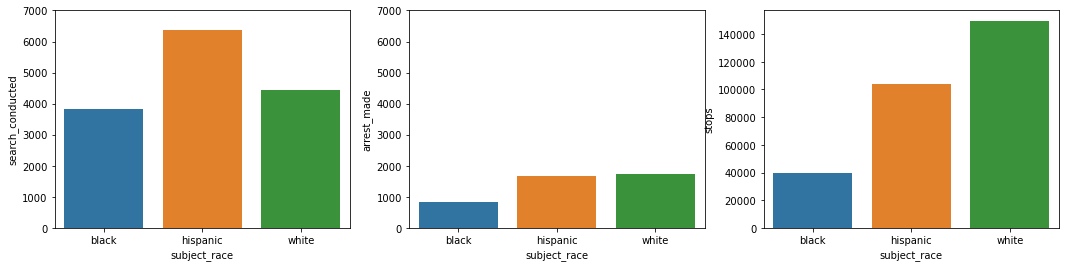

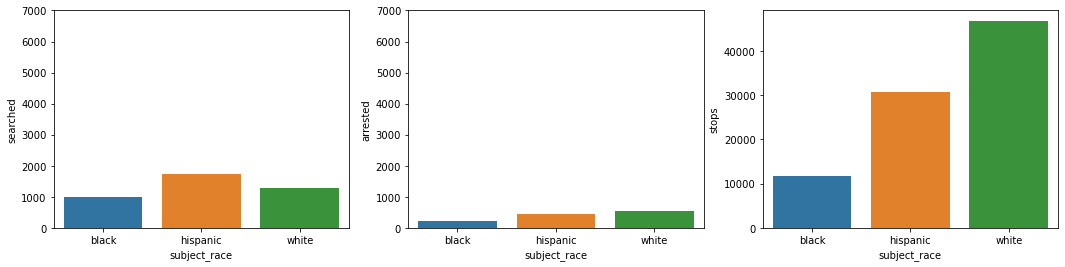

In [7]:
races = ['white','black','hispanic']
test = plots(open_data,open_primary, 
             'subject_race','search_conducted','arrest_made', races)
test_sd = plots(trimmed,sd_primary, 
             'subject_race','searched','arrested', races)

In [22]:
year_data

0         2014
1         2014
2         2014
3         2014
4         2014
          ... 
383022     NaN
383023     NaN
383024    2014
383025     NaN
383026     NaN
Name: date, Length: 383027, dtype: object

In [72]:
year_data = open_data
year_primary = open_primary
year = '2014'
year_data['date'] = open_data['date'].str.slice(0,4)
year_primary['date'] = open_primary['date'].str.slice(0,4)
data_year = year_data.loc[year_data['date']==year]
primary_year = year_primary.loc[year_primary['date']==year]

test_open_percent = table_percents(data_year,primary_year, 'subject_race',
                      'search_conducted','arrest_made', races)
test_open = tables(data_year,primary_year, 'subject_race',
                      'search_conducted','arrest_made', races)

/tmp/ipykernel_144/1401547650.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_primary['date'] = open_primary['date'].str.slice(0,4)


In [73]:
test_open 

,subject_race,search_conducted,arrest_made,stops
0,black,1579,293,15373
1,hispanic,2712,669,41479
2,white,1870,776,59272


In [96]:
test_open = table_percents(open_data,open_primary, 'subject_race',
                      'search_conducted','arrest_made', races)
test_sd = table_percents(trimmed,sd_primary, 
             'subject_race','searched','arrested', races)

In [97]:
test_open 

,subject_race,search_conducted,arrest_made,stops
0,black,9.190398,2.185110,11.354510
1,hispanic,5.638868,1.663023,29.853913
2,white,2.810082,1.189553,43.072295


In [99]:
test_open

,subject_race,search_conducted,arrest_made,stops
0,black,9.190398,2.185110,11.354510
1,hispanic,5.638868,1.663023,29.853913
2,white,2.810082,1.189553,43.072295


In [100]:
test_sd

,subject_race,searched,arrested,stops
0,black,8.543321,1.854077,10.952233
1,hispanic,5.654058,1.466132,28.854669
2,white,2.746628,1.184632,44.043959


In [10]:
list(test_sd.loc[0])

['black', 8.54332067656196, 1.854077253218884, 10.952233221460736]

In [11]:
(trimmed['service_area'].unique())

array(['430', '520', '120', '230', '440', '310', '110', '510', '930',
       '810', 'Unknown', '710', '620', '610', '320', '830', '720', '240',
       '820', '530', '630', '130'], dtype=object)

In [12]:
(open_data['service_area'].unique())

array(['110', '320', '610', '930', '820', '710', '120', '230', '240',
       '720', '430', '310', '510', 'Unknown', '810', '440', '830', '520',
       '620', '630', '130', '530', '840', 'County', 'Bulletin'],
      dtype=object)

In [32]:
service_areas = ['110', '120', '130', '230', '240', '310', '320',
                 '430', '440', '510', '520','530','610','620',
                 '630','710','720','810', '820','830', '930']
by_area_black_open = []
by_area_hispanic_open = []
by_area_white_open = []
by_area_black_sd = []
by_area_hispanic_sd = []
by_area_white_sd = []
columns = []

for x in service_areas:
    sub_area_sd = trimmed.loc[trimmed['service_area'] == x]
    sub_area_open = open_data.loc[open_data['service_area'] == x]
    sub_area_primary_sd = sd_primary.loc[sd_primary['service_area'] == x]
    sub_area_primary_open = open_primary.loc[open_primary['service_area'] == x]
    
    
    test_open = table_percents(sub_area_open,sub_area_primary_open,'subject_race',
                               'search_conducted','arrest_made', races)
    test_sd = table_percents(sub_area_sd,sub_area_primary_sd,'subject_race',
                     'searched','arrested', races)
    
    if len(test_open.loc[test_open['subject_race']=='black']) == 0:
        by_area_black_open.append(['black',0,0,0])
    else:
        by_area_black_open.append(list(test_open.loc[test_open['subject_race']=='black'].iloc[0]))
        
    if len(test_sd.loc[test_sd['subject_race']=='black']) == 0:
        by_area_black_sd.append(['black',0,0,0])
    else:
        by_area_black_sd.append(list(test_sd.loc[test_sd['subject_race']=='black'].iloc[0]))
        
    if len(test_open.loc[test_open['subject_race']=='hispanic']) == 0:
        by_area_hispanic_open.append(['hispanic',0,0,0])
    else:
        by_area_hispanic_open.append(list(test_open.loc[test_open['subject_race']=='hispanic']
                                          .iloc[0]))
        
    if len(test_sd.loc[test_sd['subject_race']=='hispanic']) == 0:
        by_area_hispanic_sd.append(['hispanic',0,0,0])
    else:
        by_area_hispanic_sd.append(list(test_sd.loc[test_sd['subject_race']=='hispanic'].iloc[0]))
    
    if len(test_open.loc[test_open['subject_race']=='white']) == 0:
        by_area_white_open.append(['white',0,0,0])
    else:
        by_area_white_open.append(list(test_open.loc[test_open['subject_race']=='white'].iloc[0]))
        
    if len(test_sd.loc[test_sd['subject_race']=='white']) == 0:
        by_area_white_sd.append(['white',0,0,0])
    else:
        by_area_white_sd.append(list((test_sd.loc[test_sd['subject_race']=='white']).iloc[0]))
    

In [33]:
list((test_sd.loc[test_sd['subject_race']=='white']).iloc[0])

['white', 2.3856300870053326, 0.7006726457399103, 53.89728096676737]

In [34]:
columns = ['subject_race','searched','arrested','stopped']
white_open = pd.DataFrame(by_area_white_open,columns = columns )
white_open['service_area'] = service_areas

white_sd = pd.DataFrame(by_area_white_sd,columns = columns )
white_sd['service_area'] = service_areas

black_open = pd.DataFrame(by_area_black_open,columns = columns )
black_open['service_area'] = service_areas

black_sd = pd.DataFrame(by_area_black_sd,columns = columns )
black_sd['service_area'] = service_areas

hispanic_open = pd.DataFrame(by_area_hispanic_open,columns = columns )
hispanic_open['service_area'] = service_areas

hispanic_sd = pd.DataFrame(by_area_hispanic_sd,columns = columns )
hispanic_sd['service_area'] = service_areas

<BarContainer object of 21 artists>

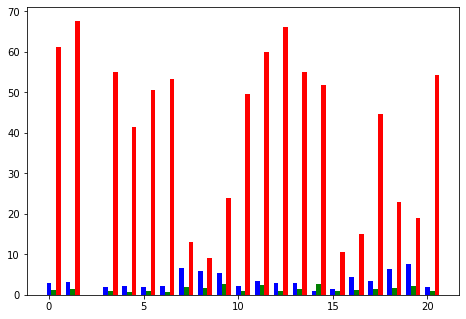

In [35]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
X = np.arange(len(service_areas))
ax.bar(X + 0.00, white_open['searched'], color = 'b', width = 0.25)
ax.bar(X + 0.25, white_open['arrested'], color = 'g', width = 0.25)
ax.bar(X + 0.50, white_open['stopped'], color = 'r', width = 0.25)


<BarContainer object of 21 artists>

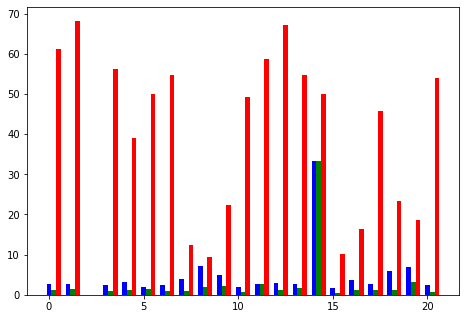

In [36]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
X = np.arange(len(service_areas))
ax.bar(X + 0.00, white_sd['searched'], color = 'b', width = 0.25)
ax.bar(X + 0.25, white_sd['arrested'], color = 'g', width = 0.25)
ax.bar(X + 0.50, white_sd['stopped'], color = 'r', width = 0.25)

In [81]:
pd_beats ="pd_beats_datasd.shx"
gdf = geopandas.read_file(pd_beats)

In [82]:
service = gdf[['serv','geometry']]
service = service.dissolve(by ='serv',aggfunc ='sum',as_index = False)
service = service.rename({'serv':'service_area'},axis='columns')

In [35]:
def geo_plots(area_data, race_data,
              area_column, subject_race_column, search_column, arrest_column, race_list):
    search_data = race_data.loc[race_data[search_column]== True]
    arrest_data = race_data.loc[race_data[arrest_column]==True]
    
    fig, axes = plt.subplots(nrows=1, ncols=3)
    fig.set_figwidth(18)
    fig.set_figheight(9)
          
    searched = (search_data[[area_column,search_column]]).groupby(
        [area_column],as_index = False).count()
    totals = (race_data[[area_column,search_column]]).groupby(
        [area_column],as_index = False).count()
    test = searched.merge(totals, on = area_column)
    # uncomment next line to get percent arrested
    # test[search_column] = (test[search_column + '_x']*100)/test[search_column + '_y']
    test[search_column] = test[search_column +'_x']
    test = test.loc[test[area_column]!='Unknown']
    test[area_column] = test[area_column].astype(int)
    joined = area_data.merge(test, on = area_column)
    fig0 = joined.plot(column = search_column, legend = True, ax = axes[0])
    fig0.set_title('Searched')
    
    arrested = (arrest_data[[area_column,arrest_column]]).groupby(
        [area_column],as_index = False).count()
    totals = (race_data[[area_column,arrest_column]]).groupby(
        [area_column],as_index = False).count()
    test = arrested.merge(totals, on = area_column)
    # uncomment next line to get percent arrested
    # test[arrest_column] = (test[arrest_column + '_x']*100)/test[arrest_column + '_y']
    test[arrest_column] = test[arrest_column +'_x']
    test = test.loc[test[area_column]!='Unknown']
    test[area_column] = test[area_column].astype(int)
    joined = area_data.merge(test, on = area_column)
    fig1 = joined.plot(column = arrest_column, legend = True, ax = axes[1])
    fig1.set_title('Arrested')

    totals = (race_data[[subject_race_column,area_column]]).groupby(
        [area_column],as_index = False).count()
    #totals['subject_race'] = (totals['subject_race'] * 100)/sum(totals['subject_race'])
    totals = totals.loc[totals[area_column]!='Unknown']
    #seaborn.barplot(data = totals, x ='service_area', y = 'subject_race')
    totals[area_column] = totals[area_column].astype(int)
    joined = area_data.merge(totals, on = area_column)
    fig2 = joined.plot(column = subject_race_column, legend = True, ax = axes[2])
    fig2.set_title('Stopped')
    axes[0].axis('off')
    axes[1].axis('off')
    axes[2].axis('off')


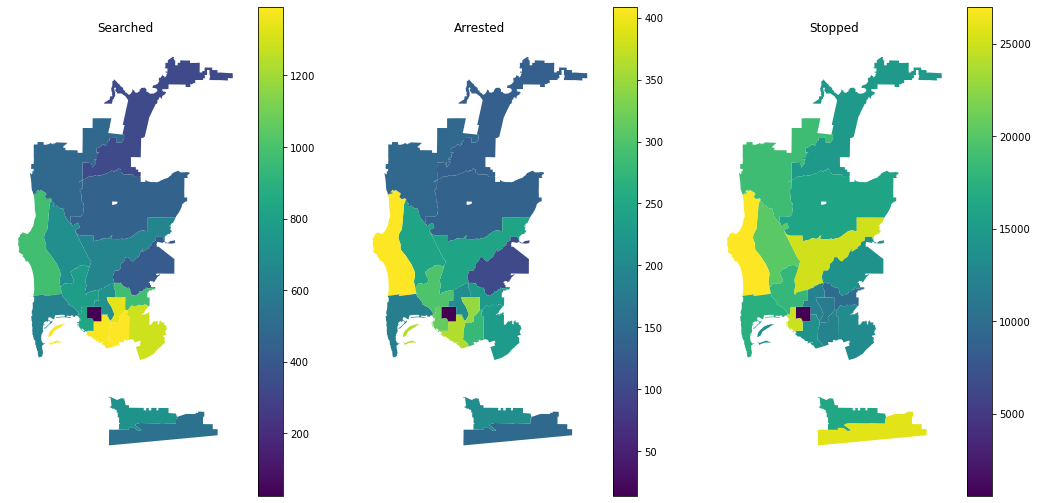

In [36]:
geo_plots(service,open_primary,'service_area',
          'subject_race','search_conducted','arrest_made', races)

In [37]:
#url = "CA_block_2010.shx"
#census_gdf = geopandas.read_file(url,nrows = 5)


In [76]:
census_file = "nhgis0006_ds239_20185_blck_grp.csv"
census_df = pd.read_csv(census_file, nrows = 5)


In [77]:

use = ['GISJOIN','COUNTY','AJZ8E001']
census_df = pd.read_csv(census_file, usecols = use)
census_df = census_df.loc[census_df['COUNTY'] == 'San Diego County']

In [78]:
url = "CA_block_2010.shx"
census_gdf = geopandas.read_file(url)
census_shape = census_gdf[['GISJOIN','geometry']]

census_shape['GISJOIN'] = census_shape['GISJOIN'].str.slice(stop = 15)

census_joined = census_shape.merge(census_df, on = 'GISJOIN')
census_joined = census_joined.to_crs(epsg = 2230)

/home/lkuo/.local/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [83]:
test = census_joined.sjoin(service, how = 'inner')
overlayed = geopandas.overlay(test,service)

In [84]:
test3 = overlayed.dissolve(by='service_area_2', aggfunc='mean', as_index = False)

In [85]:
income = test3[['service_area_2','geometry','AJZ8E001']]

In [86]:
def totals(full_data, search_column, arrest_column):
    search_data = full_data.loc[full_data[search_column]== True]
    arrest_data = full_data.loc[full_data[arrest_column]==True]
    
    stops = len(full_data)
    searches = len(search_data)
    search_prop = 100*(searches/stops)
    arrests = len(arrest_data)
    arrest_prop = 100*(arrests/stops)
    return [searches,search_prop,arrests,arrest_prop,stops]



In [87]:
service_areas = ['110', '120', '130', '230', '240', '310', '320',
                 '430', '440', '510', '520','530','610','620',
                 '630','710','720','810', '820','830', '930']
by_area = []

columns = []

for x in service_areas:
    #sub_area_sd = trimmed.loc[trimmed['service_area'] == x]
    sub_area_open = open_data.loc[open_data['service_area'] == x]
    
    by_area.append(totals(sub_area_open,'search_conducted','arrest_made'))

In [88]:

columns = ['searched','searched %','arrested','arrested %','stopped']
by_area_df = pd.DataFrame(by_area,columns = columns )
by_area_df['service_area'] = service_areas

In [89]:
income['service_area'] = income['service_area_2'].astype(str)

/home/lkuo/.local/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [90]:
joined = income.merge(by_area_df, on = 'service_area')
joined.head()

,service_area_2,geometry,AJZ8E001,service_area,searched,searched %,arrested,arrested %,stopped
0,110,"POLYGON ((6267829.065 1861399.568, 6267638.406...",102128.962931,110,766,3.152263,270,1.111111,24300
1,120,"MULTIPOLYGON (((6258804.172 1856402.029, 62588...",144057.727452,120,1057,3.427589,453,1.468967,30838
2,230,"POLYGON ((6277778.272 1918421.882, 6277850.889...",136299.334850,230,391,1.964923,156,0.783959,19899
3,240,"POLYGON ((6291997.293 1887674.356, 6291971.520...",106484.151224,240,621,2.442190,198,0.778669,25428
4,310,"POLYGON ((6281415.742 1857170.490, 6281361.228...",94984.303761,310,731,2.319825,274,0.869538,31511


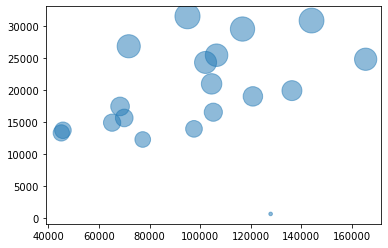

In [91]:
plt.scatter(joined['AJZ8E001'], joined['stopped'], s=joined['stopped']/50, alpha=0.5)

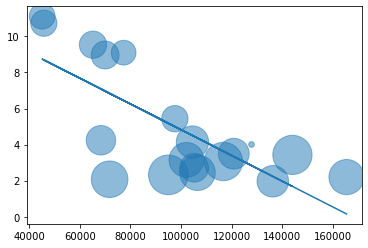

In [92]:
plt.scatter(joined['AJZ8E001'], joined['searched %'], s=joined['stopped']/20, alpha=0.5)
m, b = np.polyfit(joined['AJZ8E001'], joined['searched %'], 1)

#add linear regression line to scatterplot 
plt.plot(joined['AJZ8E001'], m*(joined['AJZ8E001'])+b)

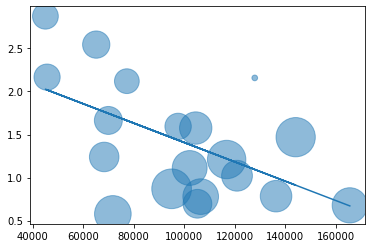

In [93]:
plt.scatter(joined['AJZ8E001'], joined['arrested %'], s=joined['stopped']/20, alpha=0.5)
m, b = np.polyfit(joined['AJZ8E001'], joined['arrested %'], 1)

#add linear regression line to scatterplot 
plt.plot(joined['AJZ8E001'], m*(joined['AJZ8E001'])+b)

(6238759.659783215, 6366830.753605561, 1764981.7294078567, 1996549.6914567687)

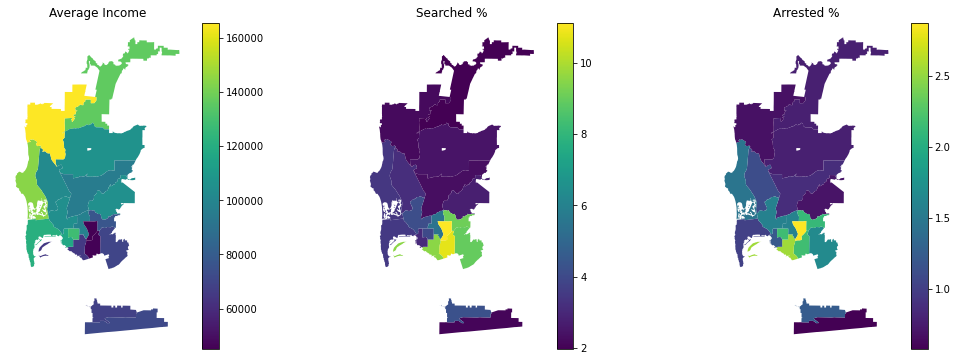

In [94]:
fig, axes = plt.subplots(nrows=1, ncols=3)

fig.set_figwidth(18)
fig.set_figheight(6)


fig0 = joined.plot(column = 'AJZ8E001', legend = True, ax = axes[0])

fig1 = joined.plot(column = 'searched %', legend = True, ax = axes[1])

fig2 = joined.plot(column = 'arrested %', legend = True, ax = axes[2])

fig0.set_title('Average Income')
fig1.set_title('Searched %')
fig2.set_title('Arrested %')
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')

(6238759.659783215, 6366830.753605561, 1764981.7294078567, 1996549.6914567687)

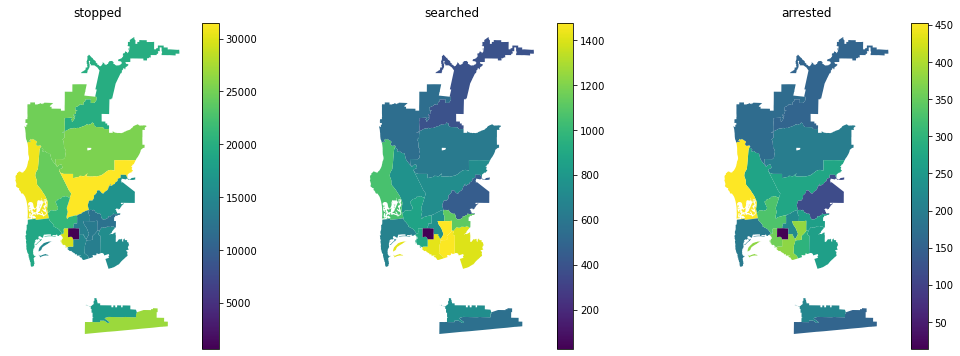

In [95]:
fig, axes = plt.subplots(nrows=1, ncols=3)

fig.set_figwidth(18)
fig.set_figheight(6)


fig0 = joined.plot(column = 'stopped', legend = True, ax = axes[0])

fig1 = joined.plot(column = 'searched', legend = True, ax = axes[1])

fig2 = joined.plot(column = 'arrested', legend = True, ax = axes[2])

fig0.set_title('stopped')
fig1.set_title('searched')
fig2.set_title('arrested')
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')